In [ ]:
%matplotlib notebook

import SimpleITK as sitk
#import itkwidgets
import os, glob, re, math, sys

In [ ]:
import filebrowser

In [3]:
f=filebrowser.FileBrowser()
print("Select an image from a series")
f.widget()

Select an image from a series


In [4]:
# strip off the last 7 characters (###.tif) and replace with *.tif
search_string = f.path[:-7]+'*.tif'
search_string

'/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned*.tif'

In [5]:
file_names = glob.glob(search_string)
file_names.sort()
print (file_names[0])
print ("  ...")
print (file_names[len(file_names)-1])
print(len(file_names), "files")

/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned000.tif
  ...
/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned161.tif
162 files


In [6]:
# Read the header of the first image to get image size
reader = sitk.ImageFileReader()
reader.SetFileName(file_names[0])
reader.ReadImageInformation()
size = reader.GetSize()
bin_amount = int(size[0]/1000+0.5)
print("Image width =", size[0])
print("Binning by", bin_amount)

Image width = 1008
Binning by 1


In [7]:
# Read the first image to compute the crop box
first_slice = reader.Execute()
non_black = (first_slice>0)
lblstats = sitk.LabelShapeStatisticsImageFilter()
lblstats.Execute(non_black)
bounding_box = lblstats.GetBoundingBox(1)
print(bounding_box)
sitk.Show(first_slice)

(0, 0, 1008, 653)


In [8]:
def process_slice(img, bin_amount, crop):
    img2 = img[ crop[0]:crop[2], crop[1]:crop[3] ]
    img3 = sitk.BinShrink(img2, [bin_amount, bin_amount])
    return img3

In [9]:
#images are shrunk to less than 1000x1000
slices = [process_slice(first_slice, bin_amount, bounding_box)]
n = len(file_names)
#n = 40

for i in range(1, n):
    try:
        slices.append( process_slice(sitk.ReadImage(file_names[i]),bin_amount, bounding_box) )
        print (i, end=' ')
    except:
        print("\nError: couldn't read file", file_names[i])
        break

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 

In [10]:
print (file_names)

['/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned000.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned001.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned002.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned003.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned004.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned005.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned006.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned007.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned008.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned009.tif', '/Users/dave/Box Sy

<IPython.core.display.Javascript object>


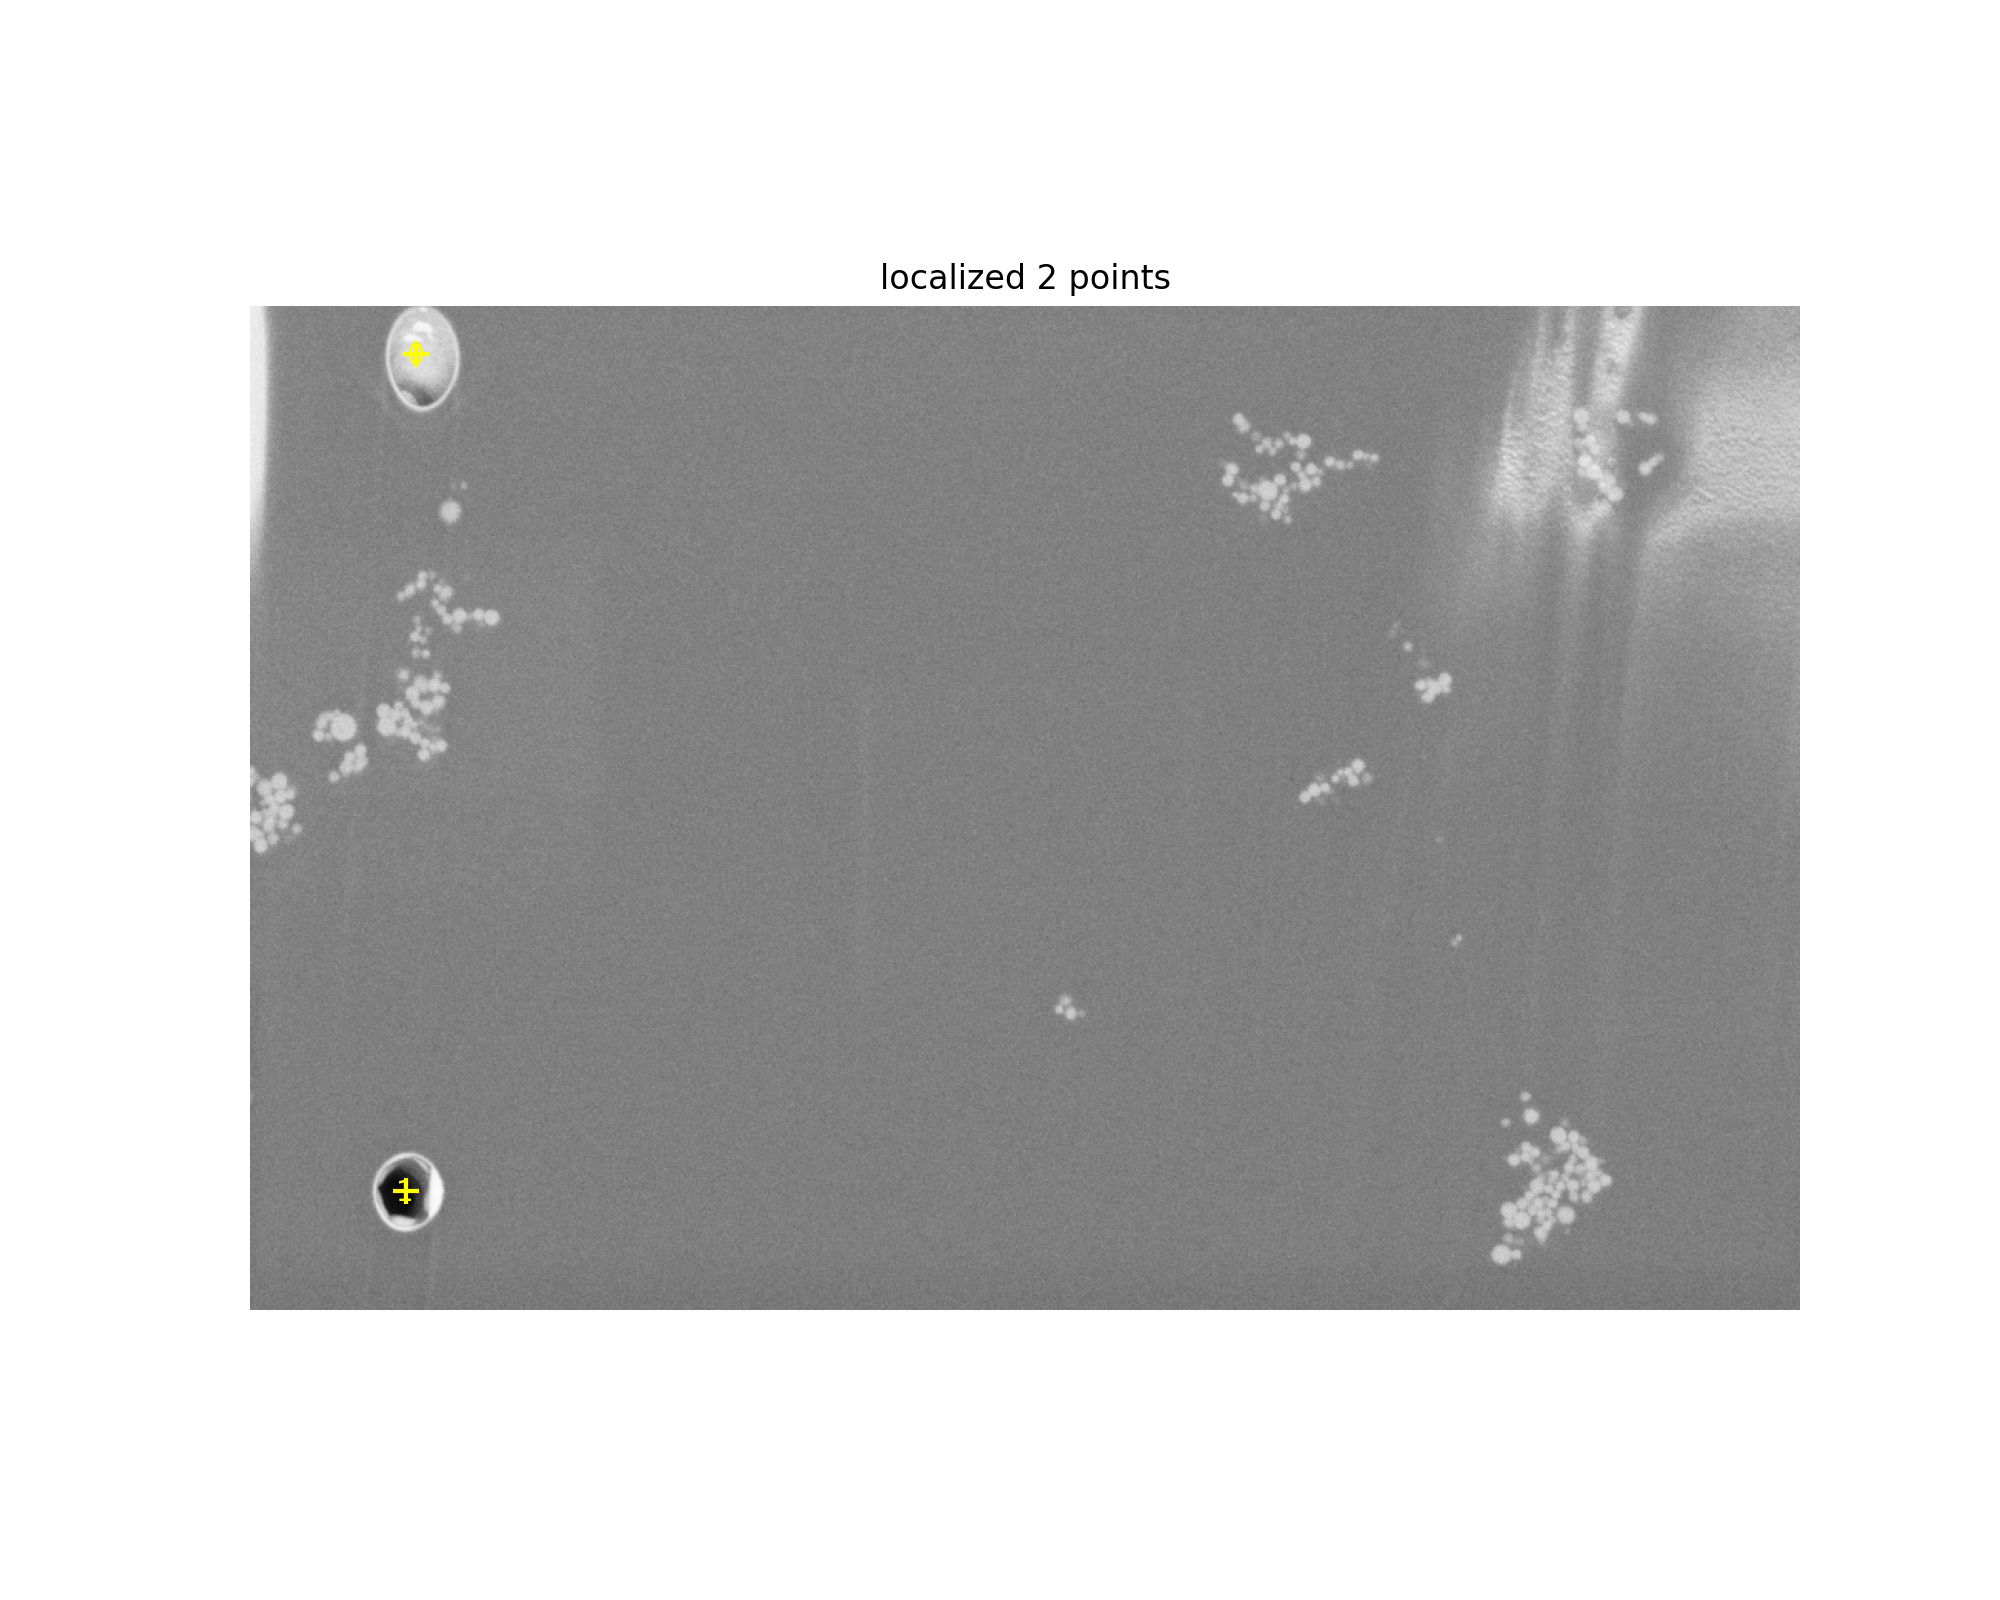

In [11]:
import gui
v = sitk.JoinSeries(slices)

acquire_centers = gui.PointDataAquisition(v)

In [13]:
import itkwidgets
itkwidgets.view(v, mode='z', cmap='Grayscale')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIma…

In [14]:
def segmentBackground(img):
    """ segment the image background.
    
    It does this by thesholding, applying a median filter,
    eroding, and selecting the largest connected component.
    """
    thresh = sitk.Median(sitk.BinaryThreshold(img, 15000, 36000),[2,2])
    erode = sitk.BinaryErode(thresh,[1,1])
    # selects the largest connected component
    connected = sitk.Cast(sitk.ConnectedComponent(erode), sitk.sitkUInt8)==1
    return connected

In [15]:
bg=[]
for s in slices:
    bg.append(segmentBackground(s))
    
v = sitk.JoinSeries(bg) * 255
itkwidgets.view(v, mode='z', cmap='Grayscale')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIma…

In [16]:
def computeExtents(img, center, radius):
    """ Compute the extents of a region in index space given its center and radius in physical space """
    # corners in physical space
    mincorner = [center[0]-radius, center[1]-radius]
    maxcorner = [center[0]+radius, center[1]+radius]
    
    minindex = list(img.TransformPhysicalPointToIndex(mincorner))
    maxindex = list(img.TransformPhysicalPointToIndex(maxcorner))
    size = img.GetSize()
    for i in range(2):
        if minindex[i]<0:
            minindex[i]=0
        if maxindex[i] >= size[i]:
            maxindex[i]=size[i]-1
    return minindex, maxindex

def findEllipse(img, center, radius, debug=False):
    """ Find an ellipse given an approximate center and radius in physical space """
    minindex, maxindex = computeExtents(img, center, radius)

    cropped = img[minindex[0]:maxindex[0], minindex[1]:maxindex[1]]
    components = sitk.ConnectedComponent(cropped,cropped)
    if debug:
        #sitk.Show(img)
        sitk.Show(components)
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(components)
    if stats.GetNumberOfLabels() == 0:
        print("Uh-oh: no labels")
        print (minindex, maxindex)
        try:
            sitk.Show(components)
        except:
            print("No show")
        return None, None
    c = stats.GetCentroid(1)
    axes = stats.GetPrincipalAxes(1)
    moments = stats.GetPrincipalMoments(1)
    #print("Center:", c)
    #print("Axes:", axes)
    return c, axes

In [17]:
seeds=[]
first_z = 0
picked_seeds = acquire_centers.get_point_indexes()
if len(picked_seeds) != 2:
    print("Warning: there should be two seed points")
    if picked_seeds[0][2] != picked_seeds[1][2]:
        print("Warning: the two seeds are on different slices, using the larger of the two.")
else:
    print(picked_seeds)

    # transform the picked seeds to physical space
    first_z = max(picked_seeds[0][2], picked_seeds[1][2])
    first_bg = bg[first_z]
    for seed in picked_seeds:
        seed_tf = first_bg.TransformIndexToPhysicalPoint(seed[0:2])
        seeds.append(seed_tf)
    print(seeds)

[(108, 30, 0), (101, 575, 0)]
[(648.0000340619443, 180.0000094616512), (606.0000318542257, 3450.0001813483145)]


In [18]:
# Locations of the two holes in physical space
# These seeds sets are used if the interactive seed picking above didn't happen.

# seeds for initial test data set: /Slice & View 01-31/Images/SEM Image
if len(seeds) == 0:
    seeds=[[962,1641],[5293,1660]]

# seeds for 2/18 data set: Slice & View 02-18/Images/SEM Multi-Detector Image
if len(seeds) == 0:
    seeds = [ [678, 216], [618,3456]]

In [19]:
radius = 500

all_ellipses = []
snum=0
for seed in seeds:
    s = seed
    z = 0
    
    # loop through all the background images
    for b in bg:
        
        # skip slices before the first_z slice we picked our seeds on
        if z<first_z:
            z = z+1
            continue
        # invert the background image to get the hole label image
        label_img = 1-b
        debugFlag = (snum==0) and (z==130)
        center, axes = findEllipse(label_img, s, radius, debugFlag)
        
        if center==None:
            print("Failed on seed", seed, "Z=",z)
            try:
                sitk.Show(label_img)
            except:
                print("No show")
            break
        
        # add Z coord for 3d ellipse
        cz = [center[0], center[1], z]
        axis1 = [axes[0], axes[1], 0]
        axis2 = [axes[2], axes[3], 0]
        ellipse = [cz, axis1, axis2]
        all_ellipses.append(ellipse)
        print(cz)

        # set this ellipse center as the seed for the next Z image
        s = center
        z=z+1


    snum=snum+1
#print(all_ellipses)

[669.9845586083392, 204.74288800460346, 0]
[668.4553542861088, 203.7595851786519, 1]
[666.4844542970288, 205.38315527182996, 2]
[663.5696821906542, 206.48380137745522, 3]
[664.5295097432447, 208.7009756005347, 4]
[662.9924672824499, 212.7048760456384, 5]
[661.6622697782993, 217.0262420942347, 6]
[661.0361971088103, 223.51661691514138, 7]
[657.1336923481177, 225.9401092182995, 8]
[660.4749205624322, 233.30366523157977, 9]
[659.0502096719653, 245.94400359309003, 10]
[658.8464590166088, 247.95311971588558, 11]
[657.1975118808427, 248.34372610102574, 12]
[656.7831957627075, 254.46863926964068, 13]
[654.6664298558115, 261.8153107516724, 14]
[657.2347744080788, 274.37281245592453, 15]
[653.429575943272, 283.2045989273192, 16]
[653.5111641290398, 293.7782598774851, 17]
[651.1789452057067, 302.0406381757327, 18]
[652.4358421553734, 311.19564954568705, 19]
[660.2865139581145, 338.5328156529838, 20]
[653.7527225363758, 336.02421121140776, 21]
[656.4745479457737, 345.5394064857051, 22]
[655.95801

[616.2250466692565, 3454.95506453281, 28]
[616.896584151138, 3455.365698871731, 29]
[617.1988863110852, 3457.38241669338, 30]
[617.3993420046355, 3457.8851069641646, 31]
[617.0471528537628, 3458.9216477858554, 32]
[615.4484680403356, 3458.9063231837868, 33]
[615.434636455725, 3459.023055722893, 34]
[614.7074353671571, 3460.3503581555883, 35]
[614.1089080201115, 3459.1776966236275, 36]
[614.108430136308, 3459.2235290636318, 37]
[613.9582661627628, 3459.325957494846, 38]
[614.2567487061482, 3458.876599725349, 39]
[614.0547768031686, 3457.923539429037, 40]
[616.4340177327585, 3457.932944601484, 41]
[614.7955713500181, 3454.1228581449477, 42]
[614.2449302468002, 3452.694059040938, 43]
[612.9293499812169, 3450.8409927016696, 44]
[611.9776857997243, 3450.6556748650796, 45]
[612.0074350077576, 3450.921834697193, 46]
[611.0834677042573, 3451.4909789726903, 47]
[610.7711610377763, 3450.348114741064, 48]
[612.0486909369877, 3449.9215787240955, 49]
[611.900401168067, 3450.3618049835595, 50]
[612.

In [20]:
import numpy as np
def ellipses2pointset(elist):
    """ convert ellipse centers to a numpy array """
    centers = []
    for e in elist:
        c = e[0]
        centers.append(c)
    np_points = np.array(centers)
    return np_points

In [21]:
pts = ellipses2pointset(all_ellipses)
#print(pts)

In [22]:
itkwidgets.view(v, mode='z', cmap='Grayscale',point_sets=[pts])

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_set_colors=array([[0.8392157, 0…

In [30]:
import ipywidgets as widgets
w = widgets.Text(
    value='',
    description='Output file'
)
display(w)

Text(value='', description='Output file')

In [34]:
print (w.value)

In [36]:
import importlib
import output
importlib.reload(output)
output.write_results(all_ellipses, w.value)

Centers
  669.98   204.74     0.00
  668.46   203.76     1.00
  666.48   205.38     2.00
  663.57   206.48     3.00
  664.53   208.70     4.00
  662.99   212.70     5.00
  661.66   217.03     6.00
  661.04   223.52     7.00
  657.13   225.94     8.00
  660.47   233.30     9.00
  659.05   245.94    10.00
  658.85   247.95    11.00
  657.20   248.34    12.00
  656.78   254.47    13.00
  654.67   261.82    14.00
  657.23   274.37    15.00
  653.43   283.20    16.00
  653.51   293.78    17.00
  651.18   302.04    18.00
  652.44   311.20    19.00
  660.29   338.53    20.00
  653.75   336.02    21.00
  656.47   345.54    22.00
  655.96   351.14    23.00
  656.55   361.88    24.00
  656.73   373.94    25.00
  655.56   385.71    26.00
  659.60   394.98    27.00
  657.06   403.35    28.00
  656.78   412.22    29.00
  659.57   428.39    30.00
  662.03   431.22    31.00
  658.62   439.28    32.00
  658.43   445.04    33.00
  654.96   452.95    34.00
  656.61   464.28    35.00
  657.04   473.42   